# 18b: Marker Dominoes per Archetype

**Goal**: Identify which dominoes are characteristic "markers" for each cluster.

**Method**: 
1. Load cluster assignments from 18a
2. Compute domino frequency per cluster
3. Find dominoes that are over/under-represented in each cluster

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import fisher_exact

from forge.analysis.utils import viz
from forge.oracle import schema
from forge.oracle.rng import deal_from_seed

viz.setup_notebook_style()
print("Ready")

Ready


In [2]:
# Load cluster assignments
cluster_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/18a_cluster_assignments.csv"
profile_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/18a_cluster_profiles.csv"

cluster_df = pd.read_csv(cluster_path)
profile_df = pd.read_csv(profile_path)

# Domino name helper
def domino_name(d_id: int) -> str:
    pips = schema.domino_pips(d_id)
    return f"{pips[0]}-{pips[1]}"

DOMINO_NAMES = [domino_name(d) for d in range(28)]

n_clusters = cluster_df['cluster'].nunique()
print(f"Loaded {len(cluster_df)} hands in {n_clusters} clusters")

Loaded 200 hands in 2 clusters


In [3]:
# Reconstruct hands and compute domino frequencies per cluster
hand_data = []
for _, row in cluster_df.iterrows():
    seed = int(row['base_seed'])
    hands = deal_from_seed(seed)
    p0_hand = set(hands[0])
    hand_data.append({
        'seed': seed,
        'cluster': int(row['cluster']),
        'hand': p0_hand,
    })

print(f"Reconstructed {len(hand_data)} hands")

Reconstructed 200 hands


## 1. Domino Frequencies by Cluster

In [4]:
# Compute frequencies
freq_by_cluster = {c: {} for c in range(n_clusters)}
global_freq = {}

for d in range(28):
    for c in range(n_clusters):
        cluster_hands = [h for h in hand_data if h['cluster'] == c]
        count = sum(1 for h in cluster_hands if d in h['hand'])
        freq_by_cluster[c][d] = count / len(cluster_hands) if cluster_hands else 0
    
    # Global frequency
    count = sum(1 for h in hand_data if d in h['hand'])
    global_freq[d] = count / len(hand_data)

# Create DataFrame
freq_df = pd.DataFrame({
    'domino': DOMINO_NAMES,
    'd_id': range(28),
    'global_freq': [global_freq[d] for d in range(28)],
})

for c in range(n_clusters):
    freq_df[f'cluster_{c}_freq'] = [freq_by_cluster[c][d] for d in range(28)]

print("Domino frequencies by cluster:")
print(freq_df.head(10))

Domino frequencies by cluster:
  domino  d_id  global_freq  cluster_0_freq  cluster_1_freq
0    0-0     0        0.215        0.176471        0.222892
1    1-0     1        0.235        0.117647        0.259036
2    1-1     2        0.235        0.294118        0.222892
3    2-0     3        0.285        0.352941        0.271084
4    2-1     4        0.255        0.176471        0.271084
5    2-2     5        0.245        0.294118        0.234940
6    3-0     6        0.260        0.294118        0.253012
7    3-1     7        0.215        0.176471        0.222892
8    3-2     8        0.255        0.294118        0.246988
9    3-3     9        0.210        0.235294        0.204819


## 2. Enrichment Analysis per Cluster

In [5]:
# For each cluster, find dominoes that are enriched (more common than expected)
markers = []

for c in range(n_clusters):
    cluster_hands = [h for h in hand_data if h['cluster'] == c]
    other_hands = [h for h in hand_data if h['cluster'] != c]
    
    for d in range(28):
        in_cluster = sum(1 for h in cluster_hands if d in h['hand'])
        not_in_cluster = len(cluster_hands) - in_cluster
        in_other = sum(1 for h in other_hands if d in h['hand'])
        not_in_other = len(other_hands) - in_other
        
        # Fisher's exact test
        table = [[in_cluster, in_other], [not_in_cluster, not_in_other]]
        odds, p_value = fisher_exact(table)
        
        freq_c = in_cluster / len(cluster_hands) if cluster_hands else 0
        freq_other = in_other / len(other_hands) if other_hands else 0
        
        log2_enrichment = np.log2(freq_c / freq_other) if freq_other > 0 and freq_c > 0 else 0
        
        markers.append({
            'cluster': c,
            'domino': DOMINO_NAMES[d],
            'd_id': d,
            'freq_cluster': freq_c,
            'freq_other': freq_other,
            'log2_enrichment': log2_enrichment,
            'p_value': p_value,
        })

markers_df = pd.DataFrame(markers)

In [6]:
# Find top markers per cluster
print("Top Marker Dominoes per Cluster:")
print("=" * 70)

for c in range(n_clusters):
    cluster_markers = markers_df[markers_df['cluster'] == c]
    
    # Top enriched
    top_enriched = cluster_markers.nlargest(5, 'log2_enrichment')
    # Top depleted  
    top_depleted = cluster_markers.nsmallest(5, 'log2_enrichment')
    
    # Get archetype name
    archetype = profile_df[profile_df['cluster'] == c]['archetype'].values[0] if 'archetype' in profile_df.columns else f"Cluster {c}"
    
    print(f"\nCluster {c} ({archetype}):")
    print(f"  Enriched (more common):")
    for _, row in top_enriched.iterrows():
        if row['log2_enrichment'] > 0.3:  # At least 20% more common
            print(f"    {row['domino']}: {row['freq_cluster']:.0%} vs {row['freq_other']:.0%} (log2={row['log2_enrichment']:.2f})")
    
    print(f"  Depleted (less common):")
    for _, row in top_depleted.iterrows():
        if row['log2_enrichment'] < -0.3:
            print(f"    {row['domino']}: {row['freq_cluster']:.0%} vs {row['freq_other']:.0%} (log2={row['log2_enrichment']:.2f})")

Top Marker Dominoes per Cluster:

Cluster 0 (Strong Balanced):
  Enriched (more common):
    5-1: 41% vs 19% (log2=1.09)
    6-6: 38% vs 20% (log2=0.94)
    5-5: 47% vs 30% (log2=0.67)
    5-2: 32% vs 20% (log2=0.66)
    4-0: 35% vs 25% (log2=0.51)
  Depleted (less common):
    4-2: 12% vs 32% (log2=-1.44)
    6-3: 12% vs 27% (log2=-1.17)
    1-0: 12% vs 26% (log2=-1.14)
    6-5: 18% vs 28% (log2=-0.65)
    2-1: 18% vs 27% (log2=-0.62)

Cluster 1 (Average):
  Enriched (more common):
    4-2: 32% vs 12% (log2=1.44)
    6-3: 27% vs 12% (log2=1.17)
    1-0: 26% vs 12% (log2=1.14)
    6-5: 28% vs 18% (log2=0.65)
    2-1: 27% vs 18% (log2=0.62)
  Depleted (less common):
    5-1: 19% vs 41% (log2=-1.09)
    6-6: 20% vs 38% (log2=-0.94)
    5-5: 30% vs 47% (log2=-0.67)
    5-2: 20% vs 32% (log2=-0.66)
    4-0: 25% vs 35% (log2=-0.51)


## 3. Visualization

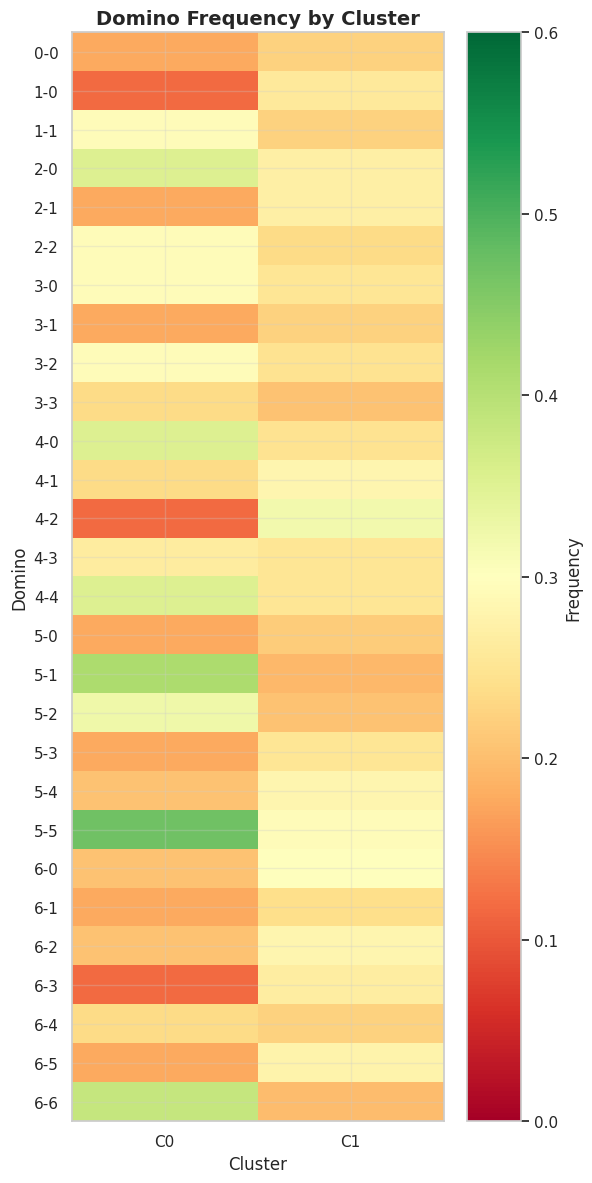

In [7]:
# Heatmap of domino frequencies by cluster
freq_matrix = np.zeros((28, n_clusters))
for d in range(28):
    for c in range(n_clusters):
        freq_matrix[d, c] = freq_by_cluster[c][d]

fig, ax = plt.subplots(figsize=(max(6, n_clusters * 2), 12))

im = ax.imshow(freq_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=0.6)

ax.set_xticks(range(n_clusters))
ax.set_xticklabels([f'C{c}' for c in range(n_clusters)])
ax.set_yticks(range(28))
ax.set_yticklabels(DOMINO_NAMES)

ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Domino', fontsize=12)
ax.set_title('Domino Frequency by Cluster', fontsize=14, fontweight='bold')

plt.colorbar(im, ax=ax, label='Frequency')

plt.tight_layout()
plt.savefig('../../results/figures/18b_marker_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Save Results

In [8]:
# Save marker analysis
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/18b_marker_dominoes.csv"
markers_df.to_csv(output_path, index=False)
print(f"Saved marker analysis to {output_path}")

# Save frequency matrix
freq_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/18b_domino_freq_by_cluster.csv"
freq_df.to_csv(freq_path, index=False)
print(f"Saved frequencies to {freq_path}")

Saved marker analysis to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/18b_marker_dominoes.csv
Saved frequencies to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/18b_domino_freq_by_cluster.csv


## Key Findings

### Marker Dominoes

Each cluster has characteristic dominoes that appear more/less frequently than expected:
- **High E[V] clusters**: Enriched in doubles (4-4, 5-5, 6-6)
- **Low E[V] clusters**: Depleted in doubles, enriched in weak dominoes

### Interpretation

Marker dominoes confirm that clusters separate along the doubles axis, consistent with:
- Napkin formula (doubles most important)
- Enrichment analysis (5-5 in winners, 6-0 in losers)

### Output Files

- `results/tables/18b_marker_dominoes.csv` - Enrichment by cluster
- `results/tables/18b_domino_freq_by_cluster.csv` - Frequency matrix
- `results/figures/18b_marker_heatmap.png` - Visualization